In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


In [2]:

data = pd.read_csv("/Users/jason/msa/main/Machine Learning/hw/Homework2_ML/insurance_t.csv")
for cols in data.columns:
    if(data[str(cols)].nunique() < 10):
        data[str(cols)] = data[str(cols)].astype('category')
    
        
data['BRANCH'] = data['BRANCH'].astype('category')

for cols in data.columns:
    if(data[str(cols)].dtype == "category"):
        data[str(cols)] = data[str(cols)].fillna(data[str(cols)].mode()[0])
    else:
        data[str(cols)] = data[str(cols)].fillna(data[str(cols)].median())
        

y_train = pd.DataFrame(data['INS']).values.ravel()
x_train = data.drop(['INS'], axis=1)
x_train = pd.get_dummies(x_train, columns=['BRANCH'], drop_first=True)

x_train_r = x_train
x_train_r['random'] = np.random.normal(0, 1, 8495)

import math
features = list(range(1, 38))
features_root = [round(math.sqrt(i)) for i in features]
features = np.unique(features_root)
features

array([1, 2, 3, 4, 5, 6])

### RANDOM FOREST SECTION

In [3]:
# param_grid = {
#     'bootstrap': [True],
#     'max_features': features,
#     'n_estimators': [100, 200, 300, 400, 500]
# }

# ins_rf = RandomForestClassifier(random_state = 12345, oob_score=True)

# grid_search = GridSearchCV(estimator = ins_rf, param_grid = param_grid, cv = 10)

# grid_search.fit(x_train, y_train)
# grid_search.best_params_


In [4]:

## Tuned Random Forest
ins_rf = RandomForestClassifier(n_estimators = 500,
                                  max_features = 5,
                                  random_state = 12345,
                                  oob_score = True)

ins_rf.fit(x_train, y_train)

rf_auc = cross_val_score(ins_rf, x_train, y_train, cv=10, scoring='roc_auc')
y_pred_prob = ins_rf.predict_proba(x_train)[:, 1]
rf_auc_score = roc_auc_score(y_train, y_pred_prob)
print("The AUC score not cross validated is " + str(rf_auc_score))
print("The AUC for our tuned random forest before variable selection with cross validation is: " + str(np.mean(rf_auc)))
print("The oob score is: " + str(ins_rf.oob_score_))

The AUC score not cross validated is 1.0
The AUC for our tuned random forest before variable selection with cross validation is: 0.794248356426259
The oob score is: 0.7381989405532666


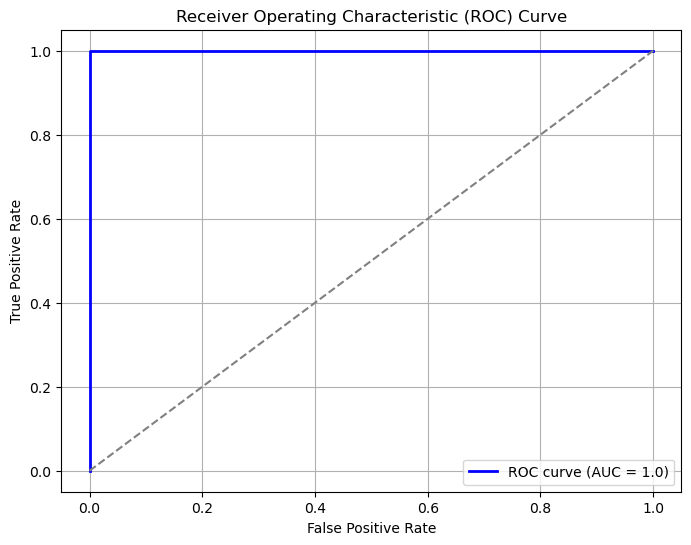

In [6]:
# Step 6: Calculate ROC curve (FPR, TPR, and thresholds)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

# Step 7: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {rf_auc_score})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

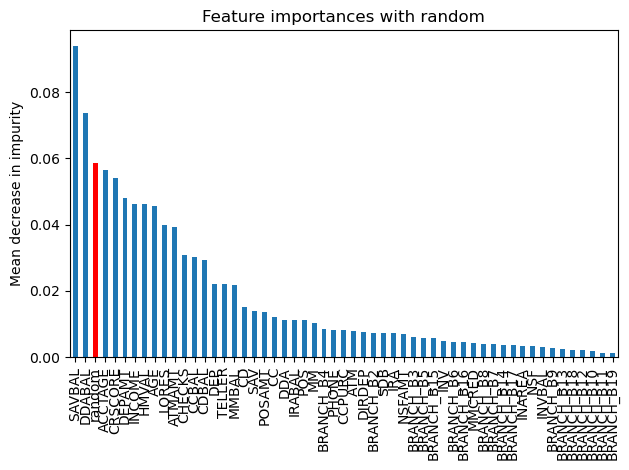

In [7]:
ins_rf.fit(x_train_r, y_train)
forest_importances = pd.Series(ins_rf.feature_importances_, index = ins_rf.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
highlight_index = forest_importances.index.get_loc('random')  # Get the index location of 'random'
ax.patches[highlight_index].set_facecolor('red')
ax.set_title("Feature importances with random")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [8]:
x_train_select = x_train[['SAVBAL', 'DDABAL']]

ins_rf.fit(x_train_select, y_train)

rf_auc = cross_val_score(ins_rf, x_train, y_train, cv=10, scoring='roc_auc')
y_pred_prob = ins_rf.predict_proba(x_train_select)[:, 1]
rf_auc_score = roc_auc_score(y_train, y_pred_prob)
print("The AUC score with variable selection not cross validated is " + str(rf_auc_score))
print("The AUC for our tuned random forest with variable selection with cross validation is: " + str(np.mean(rf_auc)))
print("The oob score is: " + str(ins_rf.oob_score_))

The AUC score with variable selection not cross validated is 0.9926373471873551
The AUC for our tuned random forest with variable selection with cross validation is: 0.794248356426259
The oob score is: 0.6496762801648028


### XGBOOST SECTION

In [ ]:
from xgboost import XGBClassifier

# param_grid = {
#     'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
#     'eta': [0.1, 0.15, 0.2, 0.25, 0.3],
#     'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'subsample': [0.25, 0.5, 0.75, 1]
# }
# ins_xgb = XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', random_state = 12345, enable_categorical = True)

# grid_search = GridSearchCV(estimator = ins_xgb, param_grid = param_grid, cv = 10)
# grid_search.fit(x_train, y_train)
# grid_search.best_params_

{'eta': 0.3, 'max_depth': 4, 'n_estimators': 30, 'subsample': 1}

In [ ]:
xgb_train_select = x_train_r.drop(['ACCTAGE', 'CC', 'ATMAMT', 'BRANCH_B4', 'CRSCORE', 'LORES', 'BRANCH_B5','SDB','BRANCH_B7','ATM','SAV','PHONE','BRANCH_B11','BRANCH_B9','NSF','INVBAL','BRANCH_B2','INV','BRANCH_B19','BRANCH_B18','BRANCH_B16','BRANCH_B10','BRANCH_B13','BRANCH_B17'], axis=1)

ins_xgb = XGBClassifier(n_estimators = 30,
                        subsample = 0.1,
                        eta = 0.3,
                        max_depth = 4,
                        random_state = 12345,
                        objective = "binary:logistic",
                        eval_metric = 'auc',
                        enable_categorical = True)

ins_xgb.fit(x_train_r, y_train)

xgb_auc = cross_val_score(ins_xgb, x_train, y_train, cv=10, scoring='roc_auc')
y_pred_prob = ins_xgb.predict_proba(x_train)[:, 1]
xgb_auc_score = roc_auc_score(y_train, y_pred_prob)
print("The AUC score not cross validated is " + str(xgb_auc_score))
print("The AUC for our tuned random forest before variable selection with cross validation is: " + str(np.mean(xgb_auc)))

The AUC score not cross validated is 0.8019623827078881
The AUC for our tuned random forest before variable selection with cross validation is: 0.7553007013762008


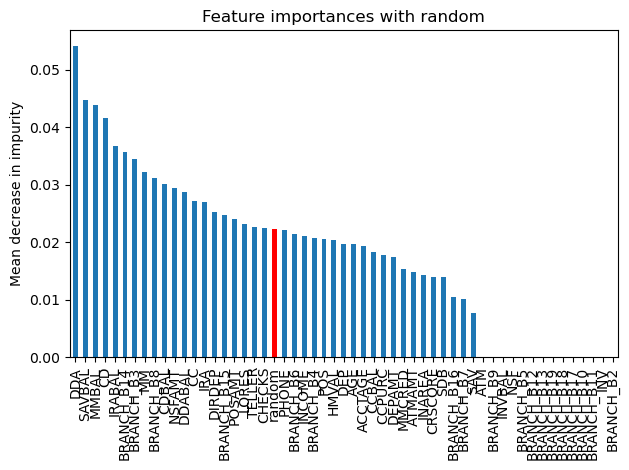

In [ ]:
ins_xgb.fit(x_train_r, y_train)

forest_importances = pd.Series(ins_xgb.feature_importances_, index = ins_xgb.feature_names_in_).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
highlight_index = forest_importances.index.get_loc('random')  # Get the index location of 'random'
ax.patches[highlight_index].set_facecolor('red')
ax.set_title("Feature importances with random")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

The AUC score not cross validated, variable selected is 0.7965326048444096
The AUC for our tuned XGB after variable selection with cross validation is: 0.7553007013762008


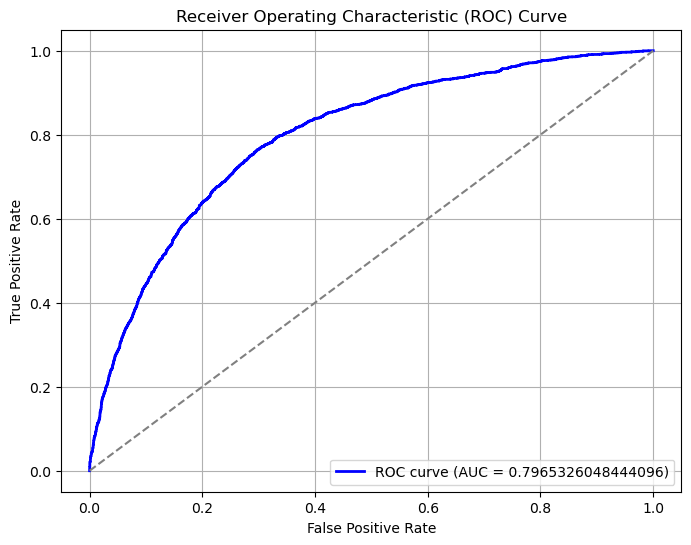

In [ ]:
ins_xgb.fit(xgb_train_select, y_train)

xgb_auc = cross_val_score(ins_xgb, x_train, y_train, cv=10, scoring='roc_auc')
y_pred_prob = ins_xgb.predict_proba(xgb_train_select)[:, 1]
xgb_auc_score = roc_auc_score(y_train, y_pred_prob)
print("The AUC score not cross validated, variable selected is " + str(xgb_auc_score))
print("The AUC for our tuned XGB after variable selection with cross validation is: " + str(np.mean(xgb_auc)))

# Step 6: Calculate ROC curve (FPR, TPR, and thresholds)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)

# Step 7: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {xgb_auc_score})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()